# Agentic RAG Data Ingestion

Wyatt Cupp <wyattcupp@gmail.com>

In [45]:
import os
import glob
import re
from langchain.document_loaders import TextLoader
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage

import prompts

## Graph State

In [46]:
from typing import TypedDict, List, Annotated
from langgraph.graph.message import add_messages, AnyMessage

MAX_RETRIES = 2

class RagIngestionState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    document_texts: List[str]
    document_ids: List[str]
    insights: List[dict]
    concepts: List[dict]
    concepts_attempts: int
    themes: List[dict]
    themes_attempts: int

## Define LLMs, Embedding Models, and Vector Store

In [47]:
llm = ChatOllama(model="deepseek-r1:14b")
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = FAISS.from_texts(["placeholder"], embedding_model) # TODO figure out best practice for vector store initialization

## Utility Functions

In [48]:
def strip_think_tags(response: str) -> str:
    """
    Remove <think> </think> tags and their contents from the LLM response when using DeepSeek R1.
    """
    return re.sub(r'<think>.*?</think>', '', response, flags=re.DOTALL).strip()

## Graph Nodes

In [49]:
def load_documents(state: RagIngestionState):
    """Load all documents into the state."""
    print("Loading documents...\n")
    document_paths = glob.glob("./documents/synthetic_meetings/*.md")
    doc_texts = []
    doc_ids = []
    for path in document_paths:
        loader = TextLoader(path)
        documents = loader.load()
        doc_texts.append(documents[0].page_content)
        doc_ids.append(os.path.basename(path).replace('.md', ''))

    print(f"Loaded {len(doc_texts)} documents: {doc_ids}\n")

    return {
        "document_texts": doc_texts,
             "document_ids": doc_ids
        }

### Insights

We extract atomic insights from documents by processing each document in two passes. In the first pass, the model generates initial insights from the full document content. In the second pass, a sliding window approach validates and refines these insights, correcting errors and ensuring accuracy by re-evaluating the content. Insights are formatted as simple subject-verb-object (SVO) sentences, written clearly as if English is a second language, enhancing precision and resolving disambiguation issues for knowledge graphs. This method excels at capturing succinct facts from tables and text alike.

See [reference](https://towardsdatascience.com/overcome-failing-document-ingestion-rag-strategies-with-agentic-knowledge-distillation/)


In [50]:
def extract_insights(state: RagIngestionState) -> dict:
    """
    Extract and validate insights from documents using a two-pass approach.
    - First pass: Extract initial insights from each document.
    - Second pass: Validate and refine insights using sliding window instructions.
    Returns updated state with insights and relevant messages.
    """
    print(f"Extracting insights from {len(state['document_texts'])} documents...\n")

    all_insights = []
    messages_to_add = []

    for doc_text, doc_id in zip(state['document_texts'][:3], state['document_ids'][:3]):
        print(f"Processing document: {doc_id}\n")

        #First Pass: Extract Initial Insights
        print(f'Performing first pass extraction for {doc_id}...')
        system_prompt = prompts.INSIGHT_EXTRACTION_PROMPT.format(transcript=doc_text)
        extraction_response = llm.invoke([
            SystemMessage(content=system_prompt),
            HumanMessage(content="Extract key insights from this document.")
        ])
        clean_response = strip_think_tags(extraction_response.content)
        initial_insights = [line.strip() for line in clean_response.split('|') if line.strip()]
        insights_with_meta = [{"text": insight, "doc_id": doc_id} for insight in initial_insights]
        messages_to_add.append(extraction_response)

        # Second Pass: Validate and Refine Insights
        print(f'Performing second pass validation for {doc_id}...')
        validation_instructions = (
            "Review the following insights extracted from the document. Perform a sliding window validation:\n"
            "- Check each insight against the full document content for accuracy and relevance.\n"
            "- Refine or correct insights as needed to ensure they are concise, accurate, and properly formatted.\n"
            "- Remove any duplicates or irrelevant insights.\n"
            "- Return the updated list of insights, separated by '|' characters."
        )
        validation_message = HumanMessage(
            content=validation_instructions + "\n\nInsights:\n" + "\n".join([f"- {insight['text']}" for insight in insights_with_meta])
        )
        validation_response = llm.invoke([
            SystemMessage(content=system_prompt),
            validation_message
        ])
        clean_validation_response = strip_think_tags(validation_response.content)
        corrected_insights = [line.strip() for line in clean_validation_response.split('|') if line.strip()]
        corrected_insights_with_meta = [{"text": insight, "doc_id": doc_id, "level": 1} for insight in corrected_insights]
        all_insights.extend(corrected_insights_with_meta)
        messages_to_add.append(validation_response)

    print(f"\nExtracted {len(all_insights)} insights from {len(state['document_texts'])} documents with an average of {len(all_insights) / len(state['document_texts'])} insights per document\n")

    return {
        "messages": messages_to_add,
        "insights": all_insights
    }


def embed_insights(state: RagIngestionState): # TODO: Include specific metadata
    """Embed insights with metadata."""
    # metadatas = [{"document": "all", "level": 1} for _ in state['insights']]
    # vector_store.add_texts(state['insights'], metadatas=metadatas)
    return state

### Concepts

Distill concepts from our lists of insights per document. The goal is to identify higher level concepts, connecting information about the document itself. For RAG, the logic follows that distilling knowledge via concepts from insights will reduce noise, redundant information, and preservation of essential information and themes.

See [reference](https://towardsdatascience.com/overcome-failing-document-ingestion-rag-strategies-with-agentic-knowledge-distillation/)


In [51]:
from typing import List, Any
from langchain_core.messages import SystemMessage, HumanMessage

llama32 = ChatOllama(model="llama3.2:3b")
def extract_concepts(state: RagIngestionState) -> dict:
    """
    Extract concepts per document from their insights, with metadata tracking and retry logic.
    
    Args:
        state (RagIngestionState): The current state containing insights and document IDs.
    
    Returns:
        dict: Updated state with concepts and messages.
    """
    print(f"Extracting concepts for {len(state['document_ids'])} documents...\n")
    all_concepts = []
    messages_to_add = []

    for doc_id in state['document_ids']:

        # grab insights for current document only
        doc_insights = [insight for insight in state['insights'] if insight['doc_id'] == doc_id]
        if not doc_insights:
            print(f"Error, no insights for document {doc_id}")
            continue
        
        insights_text = "\n".join([insight['text'] for insight in doc_insights])

        prompt = prompts.CONCEPT_EXTRACTION_PROMPT.format(insights=insights_text)
        response = llm.invoke([
            SystemMessage(content=prompt),
            HumanMessage(content=f"Generate concepts for document {doc_id} from these insights.")
        ])
        clean_response = strip_think_tags(response.content)
        concepts = [concept.strip() for concept in clean_response.split('|') if concept.strip()]

        if concepts:
            concepts_with_meta = [
                {
                    "text": concept,
                    "metadata": {
                        "doc_id": doc_id,
                        "level": 2
                    }
                }
                for concept in concepts
            ]
            all_concepts.extend(concepts_with_meta)
            messages_to_add.append(response)
    print(f"\nExtracted {len(all_concepts)} concepts from {len(state['document_ids'])} documents with an average of {len(all_concepts) / len(state['document_ids'])} concepts per document\n")
    return {
        "concepts": all_concepts,
        "messages": messages_to_add,
        "concept_attempts": state.get("concept_attempts", 0) + 1
    }

def validate_concepts(state: RagIngestionState) -> dict:
    """Validate concepts using an LLM and decide next step."""
    print(f"Validating concepts for {len(state['concepts'])} concepts...\n")
    concepts_text = "\n".join([concept['text'] for concept in state['concepts']])
    insights_text = "\n".join([insight['text'] for insight in state['insights']])
    prompt = prompts.CONCEPT_VALIDATION_PROMPT.format(concepts=concepts_text, insights=insights_text)
    response = llm.invoke([
        SystemMessage(content=prompt),
        HumanMessage(content="Evaluate these concepts.")
    ])
    decision = response.content.strip().lower()
    
    if "accept" in decision:
        return "embed_concepts"
    
    if state.get("concept_attempts") >= MAX_RETRIES:
        print(f"Warning: Concepts rejected, but Max retries hit for generating concepts. Continuing to embeddings anyways...\n")
        return "embed_concepts"
    
    print(f"Concepts rejected: {response.content}. Max retries reached, proceeding anyway.")
    return "extract_concepts"

def embed_concepts(state: RagIngestionState): # TODO: Include specific metadata
    """Embed concepts with metadata."""
    # metadatas = [{"document": "all", "level": 2} for _ in state['concepts']]
    # vector_store.add_texts(state['concepts'], metadatas=metadatas)
    return state

### Themes

In [52]:
def extract_themes(state: RagIngestionState) -> dict:
    """
    Extract 1-3 themes per document from their concepts, with metadata and retry tracking.
    
    Args:
        state (RagIngestionState): Current state with concepts and document IDs.
    
    Returns:
        dict: Updated state with themes, messages, and themes_attempts.
    """
    print(f"Extracting themes for {len(state['document_ids'])} documents...\n")
    all_themes = []
    messages_to_add = []

    for doc_id in state['document_ids']:

        # get concepts for current document only
        doc_concepts = [concept for concept in state['concepts'] if concept['metadata']['doc_id'] == doc_id]
        doc_insights = [insight for insight in state['insights'] if insight['doc_id'] == doc_id]
        if not doc_concepts:
            print(f"No concepts for document {doc_id}")
            continue
        
        concepts_text = "\n".join([concept['text'] for concept in doc_concepts])
        insights_text = "\n".join([insight['text'] for insight in doc_insights])
        prompt = prompts.THEME_EXTRACTION_PROMPT.format(concepts=concepts_text)
        
        response = llama32.invoke([
            SystemMessage(content=prompt),
            HumanMessage(content=f"Generate themes for document {doc_id}.")
        ])
        clean_response = strip_think_tags(response.content)
        themes = [theme.strip() for theme in clean_response.split('|') if theme.strip()][:3]
        
        if themes:
            themes_with_meta = [
                {
                    "text": theme,
                    "doc_id": doc_id,
                    "level": 3
                }
                for theme in themes
            ]
            all_themes.extend(themes_with_meta)
            messages_to_add.append(response)

    print(f"\nExtracted {len(all_themes)} themes from {len(state['document_ids'])} documents with an average of {len(all_themes) / len(state['document_ids'])} themes per document\n")

    return {
        "themes": all_themes,
        "messages": messages_to_add,
        "themes_attempts": state.get("themes_attempts", 0) + 1
    }

def validate_themes(state: RagIngestionState) -> str:
    """
    Validate themes using LLM and decide next step based on acceptance or retry limit.
    
    Args:
        state (RagIngestionState): Current state with themes and concepts.
    
    Returns:
        str: Next node ("embed_themes" or "extract_themes").
    """
    print(f"Validating themes for {len(state['themes'])} themes...")
    
    themes_text = "\n".join([theme['text'] for theme in state['themes']])
    concepts_text = "\n".join([concept['text'] for concept in state['concepts']])
    prompt = prompts.THEME_VALIDATION_PROMPT.format(themes=themes_text, concepts=concepts_text)
    
    response = llama32.invoke([
        SystemMessage(content=prompt),
        HumanMessage(content="Evaluate these themes.")
    ])
    decision = response.content.strip().lower()
    
    if "accept" in decision or state['themes_attempts'] >= MAX_RETRIES:
        return "embed_themes"
    else:
        print(f"Themes rejected: {response.content}. Retrying...")
        return "extract_themes"

def embed_themes(state: RagIngestionState): # TODO: Include specific metadata
    """
    Embed themes into the vector store with their metadata.
    
    Args:
        state (RagIngestionState): Current state with themes.
    
    Returns:
        RagIngestionState: Unmodified state after embedding.
    """
    # themes_texts = [theme['text'] for theme in state['themes']]
    return state

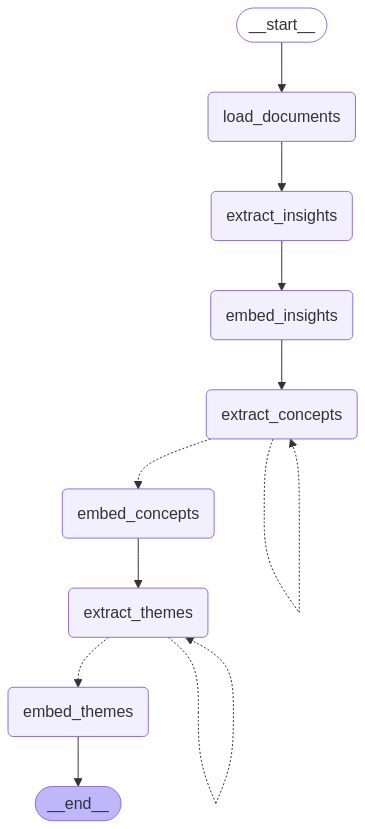

In [53]:
from IPython.display import Image, display

graph = StateGraph(RagIngestionState)

# Existing nodes
graph.add_node("load_documents", load_documents)
graph.add_node("extract_insights", extract_insights)
graph.add_node("embed_insights", embed_insights)
graph.add_node("extract_concepts", extract_concepts)
graph.add_node("embed_concepts", embed_concepts)

# New themes nodes
graph.add_node("extract_themes", extract_themes)
graph.add_node("embed_themes", embed_themes)

# Edges
graph.add_edge(START, "load_documents")
graph.add_edge("load_documents", "extract_insights")
graph.add_edge("extract_insights", "embed_insights")
graph.add_edge("embed_insights", "extract_concepts")
graph.add_conditional_edges(
    "extract_concepts",
    validate_concepts,
    {
        "extract_concepts": "extract_concepts",
        "embed_concepts": "embed_concepts"
    }
)
graph.add_edge("embed_concepts", "extract_themes")
graph.add_conditional_edges(
    "extract_themes",
    validate_themes,
    {
        "extract_themes": "extract_themes",
        "embed_themes": "embed_themes"
    }
)
graph.add_edge("embed_themes", END)

# Compile the graph
app = graph.compile()

display(Image(app.get_graph().draw_mermaid_png()))


In [54]:
initial_state = {
    "messages": [],
    "document_texts": [],
    "document_ids": [],
    "insights": [],
    "concepts": [],
    "concept_attempts": 0,
    "themes": [],
    "themes_attempts": 0,
}

final_state = app.invoke(initial_state)

print("Final State:\n")
print(f"Messages: {len(final_state['messages'])} entries")
# print(f"Document Texts: {final_state['document_texts']}")
print(f"\nDocument IDs: {final_state['document_ids']}")

print("\nInsights:")
for insight in final_state['insights']:
    print(f"Insight {insight['doc_id']}: {insight['text']}")

for concept in final_state['concepts']:
    print(f"Concept {concept['doc_id']}: {concept['text']}")

for theme in final_state['themes']:
    print(f"Theme {theme['doc_id']}: {theme['text']}")

Loading documents...

Loaded 7 documents: ['meeting5', 'meeting1', 'meeting4', 'meeting6', 'meeting10', 'meeting9', 'meeting8']

Extracting insights from 7 documents...

Processing document: meeting5

Performing first pass extraction for meeting5...
Performing second pass validation for meeting5...
Processing document: meeting1

Performing first pass extraction for meeting1...
Performing second pass validation for meeting1...
Processing document: meeting4

Performing first pass extraction for meeting4...
Performing second pass validation for meeting4...

Extracted 13 insights from 7 documents with an average of 1.8571428571428572 insights per document

Extracting concepts for 7 documents...

Error, no insights for document meeting6
Error, no insights for document meeting10
Error, no insights for document meeting9
Error, no insights for document meeting8

Extracted 3 concepts from 7 documents with an average of 0.42857142857142855 concepts per document

Validating concepts for 3 concept

AttributeError: module 'prompts' has no attribute 'CONCEPT_VALIDATION_PROMPT'

In [10]:
# Cell: Count Vectors in Vector Store
def get_vector_count(vector_store):
    """Print the total number of vectors in the FAISS index."""
    index = vector_store.index
    total_vectors = index.ntotal
    print(f"Number of vectors in vector store: {total_vectors}")

# Run the check
get_vector_count(vector_store)

Number of vectors in vector store: 120


In [12]:
msgs = llm.invoke("HI")

msgs

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [ ]:
llama = 